# 📊 Papcorns Data Scientist Technical Assessment

Bu notebook, Papcorns teknik değerlendirmesi için hazırlanmıştır. Görevler aşağıdaki başlıklar altında sırayla ele alınmıştır.

---

## 📁 1. Ortam Kurulumu ve Veritabanı Bağlantısı

In [174]:
# Gerekli kütüphaneler
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SQLite veritabanı dosyasına bağlantı oluştur
# Dosya adı 'papcorns.sqlite' – aynı dizinde olmalı
conn = sqlite3.connect('papcorns.sqlite')

## 🔍 2. Veri Keşfi (Exploratory Data Analysis)

In [177]:
# Tabloları listele
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,users
1,user_events


In [185]:
# 'users' ve 'user_events' tablolarının ilk 5 satırını inceleyerek veri yapısını gözlemliyoruz
users_df = pd.read_sql("SELECT * FROM users LIMIT 5;", conn)
events_df = pd.read_sql("SELECT * FROM user_events LIMIT 5;", conn)
users_df, events_df

(   id           created_at attribution_source country          name
 0   1  2024-05-07T00:00:00          instagram      US     Eve Brown
 1   2  2024-10-12T00:00:00          instagram      NL   Frank Moore
 2   3  2024-10-15T00:00:00             tiktok      TR  Ivy Anderson
 3   4  2024-08-28T00:00:00             tiktok      TR   Alice Brown
 4   5  2024-04-03T00:00:00            organic      NL     Bob Moore,
    id           created_at  user_id       event_name amount_usd
 0   1  2024-05-07T00:00:00        1      app_install       None
 1   2  2024-05-12T00:00:00        1    trial_started       None
 2   3  2024-05-24T00:00:00        1  trial_cancelled       None
 3   4  2024-10-12T00:00:00        2      app_install       None
 4   5  2024-10-13T00:00:00        2    trial_started       None)

## ✅ Görev 1: Ülke Bazında Toplam Abonelik Geliri
Açıklama: `subscription_started` ve `subscription_renewed` event'lerinden elde edilen toplam gelir, ülke bazında hesaplanır.

In [190]:
# SQL sorgusu: her ülke için abonelik gelirlerini toplar
# - 'subscription_started' ve 'subscription_renewed' event'lerini alır
# - 'amount_usd' boş olmayanları filtreler
# - 'users' tablosuyla birleştirerek ülke bilgisi ekler
subscription_revenue_query = """
SELECT 
    u.country,
    SUM(ue.amount_usd) AS total_subscription_revenue
FROM user_events ue
JOIN users u ON ue.user_id = u.id
WHERE ue.event_name IN ('subscription_started', 'subscription_renewed')
AND ue.amount_usd IS NOT NULL
GROUP BY u.country;
"""
revenue_by_country = pd.read_sql(subscription_revenue_query, conn)
print(revenue_by_country)

  country  total_subscription_revenue
0      NL                     3335.29
1      TR                     2275.44
2      US                     4035.96


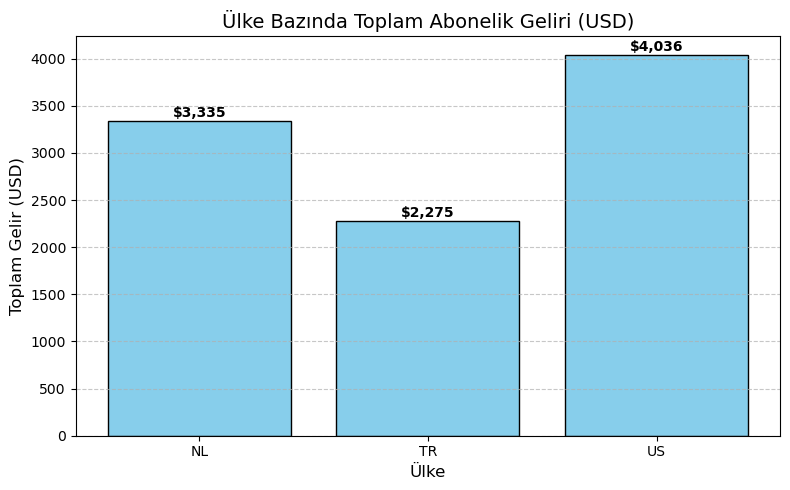

In [192]:
# Grafik boyutunu belirle
plt.figure(figsize=(8, 5))

# Çubuk grafiği oluştur (ülkeler X ekseninde, gelir Y ekseninde)
plt.bar(
    revenue_by_country["country"],                          # X ekseni: Ülke
    revenue_by_country["total_subscription_revenue"],       # Y ekseni: Toplam gelir
    color="skyblue", edgecolor="black"
)

# Grafik başlığı ve eksen etiketleri
plt.title("Ülke Bazında Toplam Abonelik Geliri (USD)", fontsize=14)
plt.xlabel("Ülke", fontsize=12)
plt.ylabel("Toplam Gelir (USD)", fontsize=12)

# Y eksenine ızgara çizgileri ekle (daha okunabilir grafik için)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Her çubuğun üstüne değer etiketlerini yaz
for index, value in enumerate(revenue_by_country["total_subscription_revenue"]):
    plt.text(index, value + 50, f"${value:,.0f}", ha='center', fontsize=10, fontweight='bold')

# Tüm öğeleri sığdırmak için düzenleme
plt.tight_layout()

# Grafiği göster
plt.show()

## ✅ Görev 2: Instagram Kullanıcılarının Başlattığı Trial Sayısı
Açıklama: `attribution_source = 'instagram'` olan kullanıcıların başlattığı `trial_started` event sayısı.

In [195]:
# SQL sorgusu:
# - 'user_events' ve 'users' tablolarını birleştirir
# - 'attribution_source' instagram olan kullanıcıları filtreler
# - Bu kullanıcıların 'trial_started' event sayısını sayar
instagram_trials_query = """
SELECT COUNT(*) AS instagram_trial_count
FROM user_events ue
JOIN users u ON ue.user_id = u.id
WHERE u.attribution_source = 'instagram'
AND ue.event_name = 'trial_started';
"""
instagram_trials = pd.read_sql(instagram_trials_query, conn)
print(instagram_trials)

   instagram_trial_count
0                    210


## ✅ Görev 3: acquisition_channel Sütunu Oluşturma
Açıklama: attribution_source'a göre `Paid` vs `Organic` olarak etiketleme yapılır.


In [198]:
# 'users' tablosunu pandas DataFrame'e yüklüyoruz
users_df = pd.read_sql("SELECT * FROM users;", conn)

# 'attribution_source' sütununa göre 'acquisition_channel' isimli yeni bir sütun oluşturuyoruz
# Eğer kullanıcı 'instagram' ya da 'tiktok' üzerinden geldiyse → "Paid"
# Diğer durumlarda (yani 'organic') → "Organic"
users_df["acquisition_channel"] = users_df["attribution_source"].apply(
    lambda x: "Paid" if x in ["instagram", "tiktok"] else "Organic"
)

In [200]:
#Etiket kontrolu icin
users_df[["attribution_source", "acquisition_channel"]].drop_duplicates()

,attribution_source,acquisition_channel
0,instagram,Paid
2,tiktok,Paid
4,organic,Organic


## ✅ Görev 4: Deneme (Trial) Başlatan Kullanıcıların Aboneliğe Geçiş Oranı (Conversion Rate) Analizi

### 🎯 Amaç:
Bu görevde, uygulamayı deneyen kullanıcıların (trial_started) daha sonra ücretli aboneliğe (subscription_started) geçme oranlarını analiz edeceğiz.

### 🔍 Yapılacaklar:
- **Genel Dönüşüm Oranı**: Tüm kullanıcılar içinde denemeden aboneliğe geçenlerin oranı hesaplanacak.
- **Kaynak Bazlı Dönüşüm**: Kullanıcının uygulamaya hangi kanal (instagram, tiktok, organic) üzerinden geldiğine göre ayrı ayrı dönüşüm oranları analiz edilecek.

### 📌 Neden Önemli?
Bu analiz sayesinde:
- Deneme özelliği ne kadar etkili? (% kaç kullanıcı ücretliye geçiyor?)
- Hangi kanal daha kaliteli kullanıcı getiriyor? (örneğin: Instagram mı yoksa Organic mi?)
- Pazarlama stratejileri veri temelli optimize edilebilir.

In [206]:
# 4a: Genel dönüşüm oranı
conversion_query = """
WITH trial_users AS (
    SELECT DISTINCT user_id FROM user_events WHERE event_name = 'trial_started'
),
subscribed_users AS (
    SELECT DISTINCT user_id FROM user_events WHERE event_name = 'subscription_started'
)
SELECT 
    (SELECT COUNT(*) FROM subscribed_users) * 1.0 / COUNT(*) AS overall_conversion_rate
FROM trial_users;
"""
overall_conversion = pd.read_sql(conversion_query, conn)

# 4b: Attribution source bazlı dönüşüm
conversion_by_source_query = """
WITH trial_events AS (
    SELECT DISTINCT ue.user_id, u.attribution_source
    FROM user_events ue
    JOIN users u ON ue.user_id = u.id
    WHERE ue.event_name = 'trial_started'
),
subscription_events AS (
    SELECT DISTINCT ue.user_id
    FROM user_events ue
    WHERE ue.event_name = 'subscription_started'
)
SELECT 
    te.attribution_source,
    COUNT(DISTINCT se.user_id) * 1.0 / COUNT(DISTINCT te.user_id) AS conversion_rate
FROM trial_events te
LEFT JOIN subscription_events se ON te.user_id = se.user_id
GROUP BY te.attribution_source;
"""
conversion_by_source = pd.read_sql(conversion_by_source_query, conn)

In [220]:
print(conversion_by_source)

  attribution_source  conversion_rate
0          instagram        70.952381
1            organic        71.610169
2             tiktok        69.067797


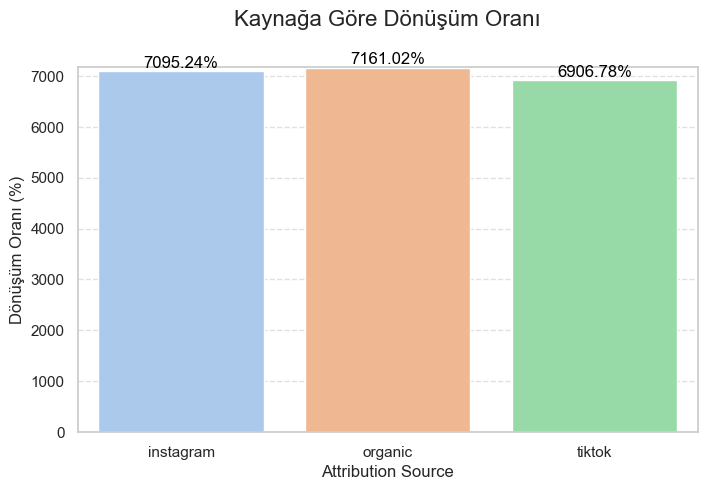

In [230]:
# Veriyi hazırla
viz_data = conversion_by_source.copy()
y_max = viz_data["conversion_rate"].max()
ylim_top = y_max + 5  # %5 boşluk yukarı

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

# Barplot çizimi
barplot = sns.barplot(
    data=viz_data,
    x="attribution_source",
    y="conversion_rate",
    hue="attribution_source",
    palette="pastel",
    legend=False
)

# Çubukların üstüne yüzde oranlarını yaz
for index, row in viz_data.iterrows():
    barplot.text(index, row["conversion_rate"] + (ylim_top * 0.01), f"{row['conversion_rate']:.2f}%", 
                 color='black', ha="center", fontsize=12)

# Başlığı biraz aşağıya çekmek için pad kullan
plt.title("Kaynağa Göre Dönüşüm Oranı", fontsize=16, pad=30)

# Ekseni ve grid ayarları
plt.xlabel("Attribution Source", fontsize=12)
plt.ylabel("Dönüşüm Oranı (%)", fontsize=12)
plt.ylim(0, ylim_top)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.subplots_adjust(top=0.88, bottom=0.15)
plt.show()

## ✅ Görev 5: Ülke Bazında Medyan Abonelik Süresi Analizi
Her bir ülke için kullanıcıların aboneliklerinin ortanca (medyan) süresi ay cinsinden hesaplanarak, bölgesel kullanıcı davranışları daha doğru bir şekilde analiz edilir.

In [240]:
# SQL sorgusu: Her kullanıcı için aboneliğin başlangıç ve bitiş tarihlerini ülke bazında çekiyoruz
subscription_dates_query = """
SELECT 
    u.country,
    ue.user_id,
    MIN(CASE WHEN ue.event_name = 'subscription_started' THEN ue.created_at END) AS sub_start,
    MAX(CASE WHEN ue.event_name = 'subscription_cancelled' THEN ue.created_at END) AS sub_end
FROM user_events ue
JOIN users u ON ue.user_id = u.id
WHERE ue.event_name IN ('subscription_started', 'subscription_cancelled')
GROUP BY u.country, ue.user_id;
"""
subscription_dates = pd.read_sql(subscription_dates_query, conn)

subscription_dates["sub_start"] = pd.to_datetime(subscription_dates["sub_start"])
subscription_dates["sub_end"] = pd.to_datetime(subscription_dates["sub_end"])

subscription_dates["duration_months"] = (subscription_dates["sub_end"] - subscription_dates["sub_start"]).dt.days / 30

median_duration_by_country = subscription_dates.groupby("country")["duration_months"].median().reset_index()

print(median_duration_by_country)

  country  duration_months
0      NL         2.316667
1      TR         2.533333
2      US         2.266667


## ✅ Görev 6: Ülke Bazında Ortalama Lifetime Value (LTV) Hesaplaması
Her bir ülke için kullanıcıların ortalama yaşam boyu değerini (LTV) hesaplayarak, bölgesel ekonomik katkı ve kullanıcı davranışları hakkında derinlemesine analiz yapılır.


In [255]:
#SQL Sorgusu
ltv_query = """
SELECT 
    u.country,
    AVG(user_total.total_amount) AS avg_ltv
FROM (
    SELECT user_id, SUM(amount_usd) AS total_amount
    FROM user_events
    WHERE event_name IN ('subscription_started', 'subscription_renewed') AND amount_usd IS NOT NULL
    GROUP BY user_id
) AS user_total
JOIN users u ON user_total.user_id = u.id
GROUP BY u.country;
"""

ltv_by_country = pd.read_sql(ltv_query, conn)

print(ltv_by_country)

  country    avg_ltv
0      NL  22.384497
1      TR  13.306667
2      US  25.068075
